<a href="https://colab.research.google.com/github/ValentinoRyo10/Machine-Learning/blob/main/CareerMatch_MLmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**EXPLORATORY DATA ANALYSIS**

*DOWNLOAD DATASET*

In [1]:
# Install library kaggle
!pip install kaggle

# Download Google Job Skills dataset dari kaggle
!kaggle datasets download -d niyamatalmass/google-job-skills

# Extract the dataset
import zipfile

with zipfile.ZipFile("google-job-skills.zip", 'r') as zip_ref:
    zip_ref.extractall("google_job_skills")

# List extracted files
import os
os.listdir("google_job_skills")


Dataset URL: https://www.kaggle.com/datasets/niyamatalmass/google-job-skills
License(s): CC-BY-NC-SA-4.0
100% 407k/407k [00:00<00:00, 814kB/s]
100% 407k/407k [00:00<00:00, 813kB/s]


['job_skills.csv']

---

*IMPORT LIBRARY*

In [103]:
# Data manipulation
import pandas as pd
import numpy as np

# Text preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer #type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences #type: ignore
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import joblib
import string
import ast
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.util import ngrams


# Label encoding and splitting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Model building
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers #type: ignore
from tensorflow.keras.models import Sequential #type: ignore
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization #type: ignore
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D #type: ignore
from tensorflow.keras.optimizers import Adam #type: ignore

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Similarity calculation
from scipy.spatial.distance import cosine

# General utilities
import os

# Checking TF version
print(tf. __version__)

2.17.1


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


*IMPORT DATASET*

In [3]:
data = pd.read_csv('/content/google_job_skills/job_skills.csv')

# Menampilkan head dataset
data.head()

,Company,Title,Category,Location,Responsibilities,Minimum Qualifications,Preferred Qualifications
0,Google,Google Cloud Program Manager,Program Management,Singapore,"Shape, shepherd, ship, and show technical prog...",BA/BS degree or equivalent practical experienc...,Experience in the business technology market a...
1,Google,"Supplier Development Engineer (SDE), Cable/Con...",Manufacturing & Supply Chain,"Shanghai, China",Drive cross-functional activities in the suppl...,BS degree in an Engineering discipline or equi...,"BSEE, BSME or BSIE degree.\nExperience of usin..."
2,Google,"Data Analyst, Product and Tools Operations, Go...",Technical Solutions,"New York, NY, United States",Collect and analyze data to draw insight and i...,"Bachelor’s degree in Business, Economics, Stat...",Experience partnering or consulting cross-func...
3,Google,"Developer Advocate, Partner Engineering",Developer Relations,"Mountain View, CA, United States","Work one-on-one with the top Android, iOS, and...",BA/BS degree in Computer Science or equivalent...,"Experience as a software developer, architect,..."
4,Google,"Program Manager, Audio Visual (AV) Deployments",Program Management,"Sunnyvale, CA, United States",Plan requirements with internal customers.\nPr...,BA/BS degree or equivalent practical experienc...,CTS Certification.\nExperience in the construc...


*DATA PREPROCESSING*

In [4]:
data.rename(columns={'Category': 'Job'}, inplace=True)

In [5]:
data = data.dropna(axis=0)

In [6]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1235 entries, 0 to 1249
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Company                   1235 non-null   object
 1   Title                     1235 non-null   object
 2   Job                       1235 non-null   object
 3   Location                  1235 non-null   object
 4   Responsibilities          1235 non-null   object
 5   Minimum Qualifications    1235 non-null   object
 6   Preferred Qualifications  1235 non-null   object
dtypes: object(7)
memory usage: 77.2+ KB
None


In [7]:
for col in data.select_dtypes(include=['category', 'object']):
    print(f"\nColumn: {col}")
    print(data[col].value_counts())


Column: Company
Company
Google     1212
YouTube      23
Name: count, dtype: int64

Column: Title
Title
Business Intern 2018                                                       35
MBA Intern, Summer 2018                                                    34
MBA Intern 2018                                                            28
BOLD Intern, Summer 2018                                                   21
Field Sales Representative, Google Cloud                                   17
                                                                           ..
Online Sales Account Strategist (Italian)                                   1
Sales Associate, Large Customer Sales                                       1
Associate Account Strategist (Polish), Google Marketing Solutions Sales     1
Business Development Consultant, Google Marketing Solutions (Italian)       1
Facilities Manager                                                          1
Name: count, Length: 779, dtype: int64

In [8]:
# Definisikan fungsi untuk mengelompokkan pekerjaan
def categorize_job(job):
    if job in ['Sales & Account Management', 'Sales Operations', 'Partnerships']:
        return 'Sales and Marketing'
    elif job in ['Finance', 'Business Strategy', 'Program Management']:
        return 'Finance and Business Strategy'
    elif job in ['Software Engineering','IT & Data Management', 'Developer Relations']:
        return 'Software Development and IT Services'
    elif job in ['Hardware Engineering', 'Technical Solutions', 'Technical Infrastructure', 'Network Engineering', 'Data Center & Network']:
        return 'Hardware Engineering and Infrastructure'
    elif job in ['Product & Customer Support', 'Administrative', 'People Operations', 'Manufacturing & Supply Chain','Real Estate & Workplace Services']:
        return 'Operations and Support'
    elif job in ['User Experience & Design', 'Technical Writing']:
        return 'Design and User Experience'
    elif job in ['Legal & Government Relations', 'Marketing & Communications']:
        return 'Legal and Communications'
    else:
        return 'Other'  # Untuk Job yang tidak terkategorisasi

# Menambahkan kolom 'Category'
data['Category'] = data['Job'].apply(categorize_job)

# Meletakkan kolom 'Category' di paling kanan
data = data[[col for col in data.columns if col != 'Category'] + ['Category']]

# Menampilkan beberapa baris untuk memverifikasi
data.head()


,Company,Title,Job,Location,Responsibilities,Minimum Qualifications,Preferred Qualifications,Category
0,Google,Google Cloud Program Manager,Program Management,Singapore,"Shape, shepherd, ship, and show technical prog...",BA/BS degree or equivalent practical experienc...,Experience in the business technology market a...,Finance and Business Strategy
1,Google,"Supplier Development Engineer (SDE), Cable/Con...",Manufacturing & Supply Chain,"Shanghai, China",Drive cross-functional activities in the suppl...,BS degree in an Engineering discipline or equi...,"BSEE, BSME or BSIE degree.\nExperience of usin...",Operations and Support
2,Google,"Data Analyst, Product and Tools Operations, Go...",Technical Solutions,"New York, NY, United States",Collect and analyze data to draw insight and i...,"Bachelor’s degree in Business, Economics, Stat...",Experience partnering or consulting cross-func...,Hardware Engineering and Infrastructure
3,Google,"Developer Advocate, Partner Engineering",Developer Relations,"Mountain View, CA, United States","Work one-on-one with the top Android, iOS, and...",BA/BS degree in Computer Science or equivalent...,"Experience as a software developer, architect,...",Software Development and IT Services
4,Google,"Program Manager, Audio Visual (AV) Deployments",Program Management,"Sunnyvale, CA, United States",Plan requirements with internal customers.\nPr...,BA/BS degree or equivalent practical experienc...,CTS Certification.\nExperience in the construc...,Finance and Business Strategy


*DATA VISUALIZATION*

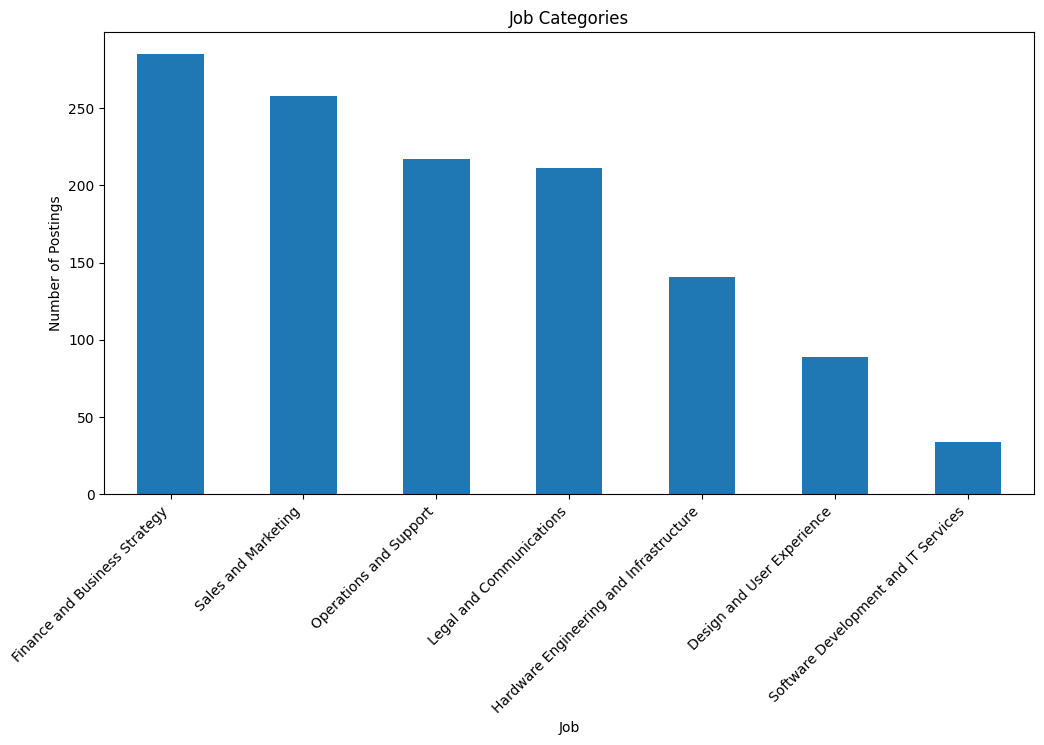

In [9]:
# Distribution of Job Categories
plt.figure(figsize=(12, 6))
data['Category'].value_counts().nlargest(10).plot(kind='bar')
plt.title('Job Categories')
plt.xlabel('Job')
plt.ylabel('Number of Postings')
plt.xticks(rotation=45, ha='right')
plt.show()

*TEXT PROCESSING*

In [25]:
# Function to extract common bigrams from a given text series
def extract_common_bigrams(text_series):
    # Combine all texts into a single string
    combined_text = ' '.join(text_series.dropna())

    # Tokenize and clean the text
    tokens = word_tokenize(combined_text.lower())
    tokens = [word for word in tokens if word not in stopwords.words('english') and word not in string.punctuation]

    # Generate bigrams
    bigrams_list = list(ngrams(tokens, 2))  # Change the number to 3 for trigrams
    bigram_counts = Counter(bigrams_list)

    # Convert tuples back to strings for better readability
    bigram_strings = [' '.join(bigram) for bigram in bigram_counts.keys()]

    return list(zip(bigram_strings, bigram_counts.values()))[:10]  # Get the 10 most common bigrams

# Group by category and extract common bigrams for Responsibilities
common_bigrams_responsibilities = data.groupby('Category')['Responsibilities'].apply(extract_common_bigrams)

# Group by category and extract common bigrams for Preferred Qualifications
common_bigrams_qualifications = data.groupby('Category')['Preferred Qualifications'].apply(extract_common_bigrams)

# Convert the results to a DataFrame for better readability
common_bigrams_responsibilities_df = common_bigrams_responsibilities.reset_index()
common_bigrams_qualifications_df = common_bigrams_qualifications.reset_index()

pd.set_option('display.max_colwidth', None)

In [26]:
common_bigrams_responsibilities_df['Responsibilities'] = common_bigrams_responsibilities_df['Responsibilities'].apply(str)
common_bigrams_responsibilities_df

,Category,Responsibilities
0,Design and User Experience,"[('write technical', 5), ('technical documentation', 5), ('documentation external', 5), ('external developer', 5), ('developer audience', 5), ('audience api', 5), ('api reference', 5), ('reference docs', 5), ('docs developer', 5), ('developer guides', 5)]"
1,Finance and Business Strategy,"[('shape shepherd', 1), ('shepherd ship', 1), ('ship show', 1), ('show technical', 1), ('technical programs', 1), ('programs designed', 1), ('designed support', 1), ('support work', 1), ('work cloud', 3), ('cloud customer', 1)]"
2,Hardware Engineering and Infrastructure,"[('collect analyze', 3), ('analyze data', 3), ('data draw', 1), ('draw insight', 1), ('insight identify', 1), ('identify strategic', 1), ('strategic solutions', 1), ('solutions build', 1), ('build consensus', 2), ('consensus facilitating', 1)]"
3,Legal and Communications,"[('develop write', 8), ('write edit', 8), ('edit communications', 8), ('communications executives', 5), ('executives including', 8), ('including emails', 8), ('emails presentations', 4), ('presentations videos', 4), ('videos work', 4), ('work advise', 4)]"
4,Operations and Support,"[('drive cross-functional', 3), ('cross-functional activities', 1), ('activities supply', 1), ('supply chain', 21), ('chain overall', 1), ('overall technical', 1), ('technical operational', 2), ('operational readiness', 1), ('readiness npi', 1), ('npi phases', 1)]"
5,Sales and Marketing,"[('lead development', 6), ('development strategy', 1), ('strategy partners', 1), ('partners healthcare', 1), ('healthcare life', 1), ('life sciences', 1), ('sciences build', 1), ('build relationships', 6), ('relationships partners', 5), ('partners focus', 2)]"
6,Software Development and IT Services,"[('work one-on-one', 3), ('one-on-one top', 3), ('top android', 3), ('android ios', 3), ('ios web', 3), ('web engineers', 3), ('engineers build', 3), ('build exciting', 3), ('exciting new', 3), ('new product/api', 3)]"


In [29]:
common_bigrams_qualifications_df['Preferred Qualifications'] = common_bigrams_qualifications_df['Preferred Qualifications'].apply(str)
common_bigrams_qualifications_df

,Category,Preferred Qualifications
0,Design and User Experience,"[('graduating ba/bs', 5), ('ba/bs degree', 5), ('degree ma/ms', 5), ('ma/ms degree', 11), ('degree 2018.', 5), ('2018. familiarity', 5), ('familiarity source', 5), ('source code', 5), ('code management', 5), ('management build', 5)]"
1,Finance and Business Strategy,"[('experience business', 1), ('business technology', 3), ('technology market', 1), ('market program', 1), ('program manager', 1), ('manager saas', 1), ('saas cloud', 2), ('cloud computing', 3), ('computing and/or', 1), ('and/or emerging', 1)]"
2,Hardware Engineering and Infrastructure,"[('experience partnering', 1), ('partnering consulting', 1), ('consulting cross-functionally', 1), ('cross-functionally senior', 1), ('senior stakeholders', 1), ('stakeholders proficiency', 1), ('proficiency database', 1), ('database query', 1), ('query language', 1), ('language e.g', 1)]"
3,Legal and Communications,"[('2 years', 5), ('years experience', 15), ('experience corporate', 4), ('corporate communications', 5), ('communications environment', 4), ('environment demonstrate', 4), ('demonstrate ability', 4), ('ability operate', 11), ('operate maintain', 4), ('maintain good', 19)]"
4,Operations and Support,"[('bsee bsme', 1), ('bsme bsie', 1), ('bsie degree', 1), ('degree experience', 9), ('experience using', 11), ('using statistics', 1), ('statistics tools', 1), ('tools data', 1), ('data analysis', 5), ('analysis e.g', 1)]"
5,Sales and Marketing,"[('ba/bs degree', 3), ('degree technical', 7), ('technical life', 1), ('life sciences', 2), ('sciences engineering', 1), ('engineering field', 1), ('field equivalent', 7), ('equivalent practical', 12), ('practical experience', 12), ('experience 5', 1)]"
6,Software Development and IT Services,"[('experience software', 7), ('software developer', 5), ('developer architect', 5), ('architect technology', 4), ('technology advocate', 3), ('advocate cto', 3), ('cto consultant', 3), ('consultant working', 5), ('working web', 3), ('web mobile', 3)]"


TEXT VECTORIZATION

In [39]:
# Define a function to preprocess text for vectorization
def preprocess_text(text_series):
    # Combine all texts into a single string
    text_series = text_series.fillna('')  # Handle NaN values
    return text_series.str.lower().str.replace('[{}]'.format(string.punctuation), '')

# Preprocess the text columns
common_bigrams_responsibilities_df['Responsibilities'] = preprocess_text(common_bigrams_responsibilities_df['Responsibilities'])
common_bigrams_qualifications_df['Preferred Qualifications'] = preprocess_text(common_bigrams_qualifications_df['Preferred Qualifications'])

# Ensure both DataFrames have the same index as the main DataFrame
common_bigrams_responsibilities_df = common_bigrams_responsibilities_df.set_index('Category')
common_bigrams_qualifications_df = common_bigrams_qualifications_df.set_index('Category')

# Combine Responsibilities and Preferred Qualifications into a single column for vectorization,
# using the index of the main DataFrame for alignment.
data['Combined Text'] = data['Category'].map(common_bigrams_responsibilities_df['Responsibilities']) + " " + data['Category'].map(common_bigrams_qualifications_df['Preferred Qualifications'])

# Handle potential NaN values after combining:
data['Combined Text'] = data['Combined Text'].fillna('')

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')  # Limit to 5000 features
X_tfidf = tfidf_vectorizer.fit_transform(data['Combined Text'])

# Convert the sparse matrix to a DataFrame for better readability
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display the first few rows of the vectorized DataFrame
print(tfidf_df.head())

# Encode the categories as labels
label_encoder = LabelEncoder()
data['Category Encoded'] = label_encoder.fit_transform(data['Category'])

# Splitting into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, data['Category Encoded'], test_size=0.2, random_state=42
)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

         11   12   15   19  2018  ability  activities  advise  advocate  \
0  0.000000  0.0  0.0  0.0   0.0      0.0    0.000000     0.0   0.00000   
1  0.082808  0.0  0.0  0.0   0.0      0.0    0.242282     0.0   0.00000   
2  0.000000  0.0  0.0  0.0   0.0      0.0    0.000000     0.0   0.00000   
3  0.000000  0.0  0.0  0.0   0.0      0.0    0.000000     0.0   0.24515   
4  0.000000  0.0  0.0  0.0   0.0      0.0    0.000000     0.0   0.00000   

   analysis  ...  technical  technology     tools     using  videos     web  \
0  0.000000  ...   0.133052    0.227624  0.000000  0.000000     0.0  0.0000   
1  0.242282  ...   0.121746    0.000000  0.242282  0.242282     0.0  0.0000   
2  0.000000  ...   0.000000    0.000000  0.000000  0.000000     0.0  0.0000   
3  0.000000  ...   0.000000    0.126290  0.000000  0.000000     0.0  0.4903   
4  0.000000  ...   0.133052    0.227624  0.000000  0.000000     0.0  0.0000   

       work  working  write  years  
0  0.178597  0.00000    0.0    0.0  


In [40]:
# Check the first few rows of preprocessed text
data[['Responsibilities', 'Preferred Qualifications', 'Combined Text']].head()

,Responsibilities,Preferred Qualifications,Combined Text
0,"shape, shepherd, ship, and show technical programs designed to support the work of cloud customer engineers and solutions architects.\nmeasure and report on key metrics tied to those programs to identify any need to change course, cancel, or scale the programs from a regional to global platform.\ncommunicate status and identify any obstacles and paths for resolution to stakeholders, including those in senior roles, in a transparent, regular, professional and timely manner.\nestablish expectations and rationale on deliverables for stakeholders and program contributors.\nprovide program performance feedback to teams in product, engineering, sales, and marketing (among others) to enable efficient cross-team operations.","experience in the business technology market as a program manager in saas, cloud computing, and/or emerging technologies.\nsignificant cross-functional experience across engineering, sales, and marketing teams in cloud computing or related technical fields.\nproven successful program outcomes from idea to launch in multiple contexts throughout your career.\nability to manage the expectations, demands and priorities of multiple internal stakeholders based on overarching vision and success for global team health.\nability to work under pressure and possess flexibility with changing needs and direction in a rapidly-growing organization.\nstrong organization and communication skills.","shape shepherd shepherd ship ship show show technical technical programs programs designed designed support support work work cloud cloud customer [('experience business', 1), ('business technology', 3), ('technology market', 1), ('market program', 1), ('program manager', 1), ('manager saas', 1), ('saas cloud', 2), ('cloud computing', 3), ('computing and/or', 1), ('and/or emerging', 1)]"
1,"drive cross-functional activities in the supply chain for overall technical operational readiness in all npi phases leading into mass production.\ncollaborate with suppliers and engineering teams in assessing process technologies based on project requirements, and propose and develop the manufacturing blueprint including process flow, equipment/fixture designs, implementation schedules and validation plans for engineering builds and mass production.\ndrive project technical and operational issues with material, process, fixtures, equipment, etc. during the npi phase to enable delivery of a mature product and manufacturing process into mass production. support/drive continuous improvement efforts in the supply chain.\nlead suppliers by providing technical direction to establish and validate (utilizing statistical tools) process capability during the npi phase for consistently delivering a quality product in mass production.\nutilize doe’s, fmea and other industry standard tools to proactively identify and address risks and optimize process parameters.","bsee, bsme or bsie degree.\nexperience of using statistics tools for data analysis, e.g. distribution histogram/pareto chart, process control chart, design of experiment (doe), correlation analysis, etc.\ndemonstrated knowledge in pcba manufacturing process and quality control.\nfamilar with cable/connector related components' manufacturing: moldling, stamping, die-casting, lim, mim process and materials.\nself starter with innovation, integrity and attention to detail.\nability to travel up to 50% of the time","drive cross-functional cross-functional activities activities supply supply chain chain overall overall technical technical operational operational readiness readiness npi npi phases [('bsee bsme', 1), ('bsme bsie', 1), ('bsie degree', 1), ('degree experience', 9), ('experience using', 11), ('using statistics', 1), ('statistics tools', 1), ('tools data', 1), ('data analysis', 5), ('analysis e.g', 1)]"
2,"collect and analyze data to draw insight and identify strategic solutions.\nbuild consensus by facilitating broad collaboration with

In [41]:
# Check the shape of the TF-IDF matrix
print(f"TF-IDF Matrix Shape: {X_tfidf.shape}")

# Display the first few rows of the TF-IDF DataFrame
print(tfidf_df.head())

# Display the vocabulary (top 10 terms)
print(f"Top 10 Terms: {tfidf_vectorizer.get_feature_names_out()[:10]}")

TF-IDF Matrix Shape: (1235, 125)
         11   12   15   19  2018  ability  activities  advise  advocate  \
0  0.000000  0.0  0.0  0.0   0.0      0.0    0.000000     0.0   0.00000   
1  0.082808  0.0  0.0  0.0   0.0      0.0    0.242282     0.0   0.00000   
2  0.000000  0.0  0.0  0.0   0.0      0.0    0.000000     0.0   0.00000   
3  0.000000  0.0  0.0  0.0   0.0      0.0    0.000000     0.0   0.24515   
4  0.000000  0.0  0.0  0.0   0.0      0.0    0.000000     0.0   0.00000   

   analysis  ...  technical  technology     tools     using  videos     web  \
0  0.000000  ...   0.133052    0.227624  0.000000  0.000000     0.0  0.0000   
1  0.242282  ...   0.121746    0.000000  0.242282  0.242282     0.0  0.0000   
2  0.000000  ...   0.000000    0.000000  0.000000  0.000000     0.0  0.0000   
3  0.000000  ...   0.000000    0.126290  0.000000  0.000000     0.0  0.4903   
4  0.000000  ...   0.133052    0.227624  0.000000  0.000000     0.0  0.0000   

       work  working  write  years  
0  0

In [42]:
# Check unique labels and their encoding
print(f"Unique Categories: {data['Category'].unique()}")
print(f"Encoded Labels: {data['Category Encoded'].unique()}")

# Display the mapping between categories and encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Unique Categories: ['Finance and Business Strategy' 'Operations and Support'
 'Hardware Engineering and Infrastructure'
 'Software Development and IT Services' 'Sales and Marketing'
 'Design and User Experience' 'Legal and Communications']
Encoded Labels: [1 4 2 6 5 0 3]
Label Mapping: {'Design and User Experience': 0, 'Finance and Business Strategy': 1, 'Hardware Engineering and Infrastructure': 2, 'Legal and Communications': 3, 'Operations and Support': 4, 'Sales and Marketing': 5, 'Software Development and IT Services': 6}


In [43]:
# Check the shapes of the splits
print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

# Check the distribution of labels in training and testing sets
print("Training Set Label Distribution:")
print(pd.Series(y_train).value_counts())

print("Testing Set Label Distribution:")
print(pd.Series(y_test).value_counts())

Training Data Shape: (988, 125)
Testing Data Shape: (247, 125)
Training Set Label Distribution:
Category Encoded
1    229
5    200
3    176
4    168
2    114
0     75
6     26
Name: count, dtype: int64
Testing Set Label Distribution:
Category Encoded
5    58
1    56
4    49
3    35
2    27
0    14
6     8
Name: count, dtype: int64


In [80]:
# Sample check
sample_index = 23 # Change this to check different rows
print(f"Sample Text: {data['Combined Text'].iloc[sample_index]}")
print(f"TF-IDF Vector (Sparse Format): {X_tfidf[sample_index]}")
print(f"Encoded Category: {y_train[sample_index]}")
print(f"Original Category: {label_encoder.inverse_transform([y_train[sample_index]])[0]}")


Sample Text: shape shepherd shepherd ship ship show show technical technical programs programs designed designed support support work work cloud cloud customer [('experience business', 1), ('business technology', 3), ('technology market', 1), ('market program', 1), ('program manager', 1), ('manager saas', 1), ('saas cloud', 2), ('cloud computing', 3), ('computing and/or', 1), ('and/or emerging', 1)]
TF-IDF Vector (Sparse Format):   (0, 103)	0.11924908228705443
  (0, 104)	0.23849816457410886
  (0, 105)	0.23849816457410886
  (0, 115)	0.13305158159975836
  (0, 95)	0.23849816457410886
  (0, 39)	0.23849816457410886
  (0, 114)	0.23849816457410886
  (0, 121)	0.17859682743697114
  (0, 23)	0.4769963291482177
  (0, 34)	0.11924908228705443
  (0, 56)	0.052020761648645886
  (0, 21)	0.23849816457410886
  (0, 116)	0.22762390420066136
  (0, 79)	0.23849816457410886
  (0, 94)	0.23849816457410886
  (0, 78)	0.23849816457410886
  (0, 100)	0.23849816457410886
  (0, 27)	0.23849816457410886
  (0, 49)	0.119249

In [93]:
# Encode Category
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data['Category'])  # Mengubah kategori menjadi angka

In [111]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_encoded, test_size=0.2, random_state=42)

# Pad sequences to ensure consistent input size
max_length = 100  # Define the maximum length of sequences
X_train_padded = pad_sequences(X_train.toarray(), maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test.toarray(), maxlen=max_length, padding='post')

# Define the model architecture
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))  # Prevent overfitting
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Prevent overfitting
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2525 - loss: 1.8929 - val_accuracy: 0.6599 - val_loss: 1.4236
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5143 - loss: 1.2812 - val_accuracy: 0.9109 - val_loss: 0.5445
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8204 - loss: 0.5518 - val_accuracy: 1.0000 - val_loss: 0.1182
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9355 - loss: 0.1994 - val_accuracy: 1.0000 - val_loss: 0.0306
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9827 - loss: 0.0732 - val_accuracy: 1.0000 - val_loss: 0.0091
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9932 - loss: 0.0356 - val_accuracy: 1.0000 - val_loss: 0.0039
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9948 - loss: 0.0241 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9967 - loss: 0.0193 - val_accuracy: 1.0000 - val_loss

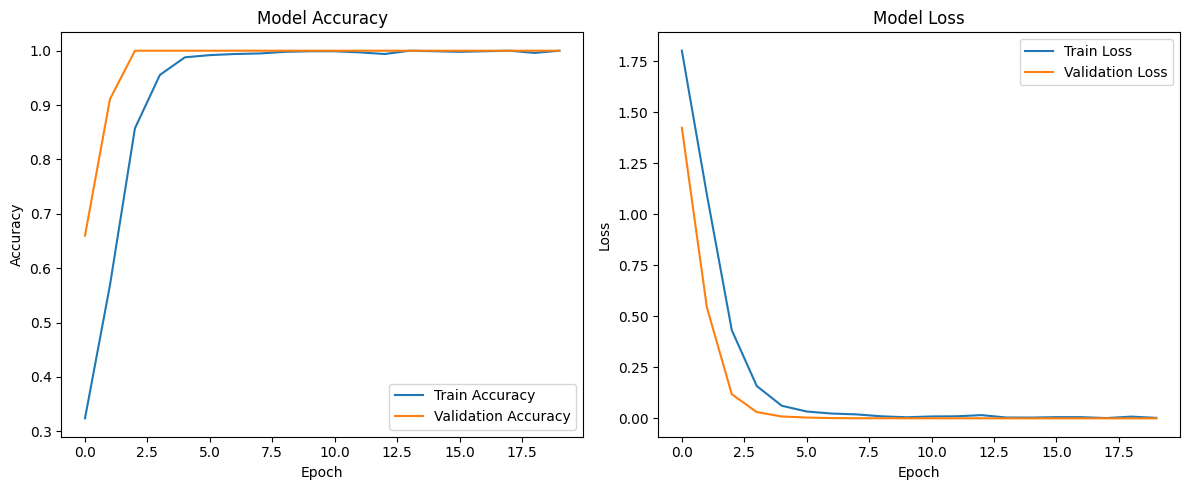

In [113]:
import matplotlib.pyplot as plt

# Step 1: Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Step 2: Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Step 3: Show the plots
plt.tight_layout()
plt.show()